The primary objective of this competition is to employ deep learning-based regression models, such as Convolutional Neural Networks (CNNs) like ConvNext or Transformers, to predict plant traits from photographs. These plant traits, although available for each image, may not yield exceptionally high accuracies due to the inherent heterogeneity of citizen science data. The various plant traits describe chemical tissue properties that are loosely related to the visible appearance of plants in images. Despite the anticipated moderate accuracies, the overarching goal is to explore the potential of this approach and gain insights into global changes affecting ecosystems. Your contribution to uncovering the wealth of data and the distribution of plant traits worldwide is invaluable.

Our goal is to predict a broad set of 6 plant traits (e.g. leaf area, plant height) from crowd-sourced plant images and some ancillary data. 

The models will be evaluated against the independent test data. The evaluation metric for this competition is the mean R2 over all 6 traits. The R2 is commonly used for evaluating regression models and is the ratio of the sum of squares the residuals (SSres) to the total sum of squares (SStot).

The R2 can result in large negative values. To prevent that we will only consider R2 values > 0.

The submission should include a .csv file with a prediction for each trait and the following columns: id (see labels) and a prediction for each trait (X1080, X50, …). An example is given with sample_submission.csv


In [1]:
#imports and variables
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_DIR = os.getcwd() +'/data/' #data directory kaggle: /kaggle/input/planttraits2024/

In [23]:
class CONFIG:
    sub = f"{DATA_DIR}sample_submission.csv"
    trgts = f"{DATA_DIR}target_name_meta.tsv"
    train_path = f"{DATA_DIR}train.csv"
    test_path = f"{DATA_DIR}test.csv"
    train_image_path = f"{DATA_DIR}train_images/"
    test_image_path = f"{DATA_DIR}test_images/"
    SEED = 42 #seed for reproducibility
    IMAGE_SIZE = [224, 224] 
    BATCH_SIZE = 64
    EPOCHS = 5
    MLP_EPOCHS = 30
    CLASS_NAMES  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'] #target columns in dataset to predict
    PREDICTOR_NAMES = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
    
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), CLASS_NAMES))
    num_classes = len(CLASS_NAMES)
    aux_num_classes = len(aux_class_names)

config = CONFIG()
len(CONFIG.CLASS_NAMES)

6

In [3]:
#load train.csv and test.csv as pandas dataframe
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)

In [4]:
#add image path to the dataframe
train['image_path'] = f'{DATA_DIR}/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = f'{DATA_DIR}/test_images/' + test['id'].astype(str) + '.jpeg'

# drop missing values in the target columns
train = train.drop_duplicates(subset=['id']).dropna(subset=CONFIG.CLASS_NAMES)
display(train.head(2))

FEATURE_COLS = test.columns[1:-1].tolist()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,D:\Adulthood funkek\NUS Master in AI\Semester ...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,D:\Adulthood funkek\NUS Master in AI\Semester ...


In [5]:
#this is just to check if everything is working fine
train.loc[train['id'] == 100010249, config.CLASS_NAMES]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
24553,0.47654,11.378406,6.366832,45.152675,1.910018,3937.028466


In [6]:
#additional libraries
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [7]:
#CNN uses only target columns for training, and image_path
train_cnn = train[['id', 'image_path'] + config.CLASS_NAMES]


#MLP uses all tabular features
train_all_tabular = train.iloc[:, 1:-7]
test_tabular_df = test.iloc[:,1:-1]

#use 80/20 split
train_cnn_df, val_cnn_df = train_test_split(train_cnn, test_size=0.2, random_state=config.SEED)
train_tabular_df, val_tabular_df = train_test_split(train_all_tabular, test_size=0.2, random_state=config.SEED)

print(f"CNN Train shape: {train_cnn_df.shape}, CNN Validation shape: {val_cnn_df.shape}")
print(f"MLP Train shape: {train_tabular_df.shape}, MLP Validation shape: {val_tabular_df.shape}")
print(f"MLP Test shape: {test_tabular_df.shape}")


CNN Train shape: (44391, 8), CNN Validation shape: (11098, 8)
MLP Train shape: (44391, 169), MLP Validation shape: (11098, 169)
MLP Test shape: (6545, 163)


In [8]:
#setup CNN dataloaders
class PlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        target = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target
    
#setup MLP dataloaders
class PlantTabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_input_dimensions(self):
        return self.X.size(1)
    
    def get_output_dimensions(self):
        return self.y.size(1)

In [9]:
#Input preprocessing
##setup CNN data augmentation
train_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#setup MLP preprocessing
##split tabular input and targets
train_input = train_tabular_df.iloc[:,:-6]
train_output = train_tabular_df.iloc[:,-6:]
val_input = val_tabular_df.iloc[:,:-6]
val_output = val_tabular_df.iloc[:,-6:]
test_input = test_tabular_df

#normalize input with MinMax
scaler = MinMaxScaler()
scaler.fit(train_input)
train_input = scaler.transform(train_input)
val_input = scaler.transform(val_input)
test_input = scaler.transform(test_input)

#normalize targets with log10, except for first target (X4_mean)
train_output[config.CLASS_NAMES[1:]] = train_output[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))
val_output[config.CLASS_NAMES[1:]] = val_output[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))

train_cnn_df[config.CLASS_NAMES[1:]] = train_cnn_df[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))
val_cnn_df[config.CLASS_NAMES[1:]] = val_cnn_df[config.CLASS_NAMES[1:]].apply(lambda x: np.log10(x))


In [10]:
#setup CNN dataloaders
train_dataset = PlantDataset(paths= train_cnn_df['image_path'].tolist(), labels= train_cnn_df[config.CLASS_NAMES].values, transform=train_transforms)
val_dataset = PlantDataset(paths= val_cnn_df['image_path'].tolist(), labels= val_cnn_df[config.CLASS_NAMES].values, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

#setup MLP dataloaders
train_tabular_data = PlantTabularDataset(train_input, train_output)
val_tabular_data = PlantTabularDataset(val_input, val_output)
test_tabular_data = torch.tensor(test_input, dtype=torch.float32)

train_tabular_loader = DataLoader(train_tabular_data, shuffle=True, batch_size=config.BATCH_SIZE)
val_tabular_loader = DataLoader(val_tabular_data, batch_size=len(val_tabular_data))

#create params for configuration
dataset_sizes = len(train_cnn_df), len(val_cnn_df)
total_epochs = config.EPOCHS
batch_size = config.BATCH_SIZE
total_train_steps = dataset_sizes[0] * total_epochs * batch_size
warmup_steps =  total_train_steps//10
decay_steps = total_train_steps - warmup_steps

display(f"data sizes: {dataset_sizes}, total epochs: {total_epochs}, batch size: {batch_size}, total train steps: {total_train_steps}, warmup steps: {warmup_steps}, decay steps: {decay_steps}")


'data sizes: (44391, 11098), total epochs: 8, batch size: 64, total train steps: 22728192, warmup steps: 2272819, decay steps: 20455373'

In [11]:
train_loader.dataset[random.randint(0,dataset_sizes[0])]

(tensor([[[-0.1486, -0.1486, -0.1314,  ..., -0.1486, -0.3027, -0.3027],
          [-0.1143, -0.0801, -0.1143,  ..., -0.1143, -0.2684, -0.3541],
          [-0.1314, -0.1314, -0.1314,  ..., -0.1143, -0.2684, -0.3027],
          ...,
          [-0.9363, -0.7993, -0.4739,  ..., -0.9363, -1.0048, -1.0219],
          [-0.9705, -0.7479, -0.1999,  ..., -0.4054, -0.8335, -1.0904],
          [-0.9705, -0.5082, -0.2856,  ...,  1.3927,  0.8789, -0.1828]],
 
         [[-0.0049, -0.0049,  0.0126,  ...,  0.4153,  0.3102,  0.3803],
          [ 0.0476,  0.0651,  0.0651,  ...,  0.4503,  0.3627,  0.2752],
          [ 0.0476,  0.0651,  0.0651,  ...,  0.4328,  0.3627,  0.2927],
          ...,
          [-1.6856, -1.5105, -1.1078,  ..., -0.9153, -0.9678, -0.9853],
          [-1.5980, -1.3179, -0.7052,  ..., -0.4251, -0.8452, -1.0728],
          [-1.5455, -1.0378, -0.7227,  ...,  1.5182,  0.9580, -0.0924]],
 
         [[-0.0267,  0.0256,  0.1651,  ..., -0.1138, -0.2184, -0.1661],
          [ 0.0605,  0.1476,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


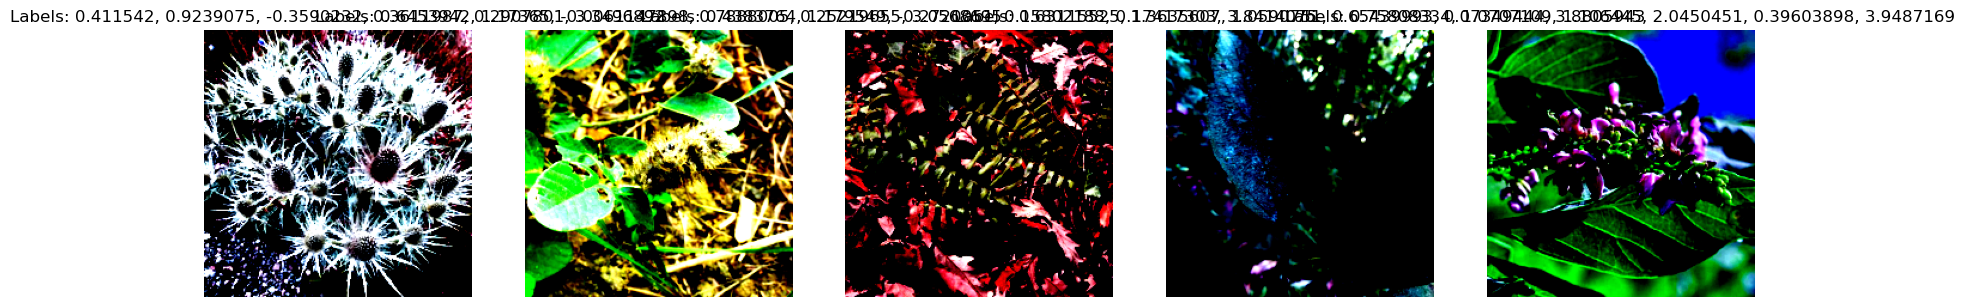

In [12]:
#visualize input images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  
        axes[idx].imshow(image)
        label_str = ", ".join([str(val) for val in label])  
        axes[idx].set_title(f"Labels: {label_str}")
        axes[idx].axis("off")
    plt.show()

num_images_to_display = 5
sample_indices = torch.randint(len(train_dataset), size=(num_images_to_display,))
sample_images = [train_dataset[i][0] for i in sample_indices]
sample_labels = [train_dataset[i][1] for i in sample_indices]

sample_labels_np = [label.numpy() for label in sample_labels]

show_images(sample_images, sample_labels_np)



In [13]:
#setup model
import torch.nn as nn
import tqdm as notebook_tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PlantModelResNet(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

class PlantModelCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


#setup MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=64)
        self.hidden_1 = nn.Linear(in_features=64, out_features=64)
        self.bn1 = nn.BatchNorm1d(64)
        self.hidden_2 = nn.Linear(in_features=64, out_features=16)
        self.bn2 = nn.BatchNorm1d(64)
        self.hidden_3 = nn.Linear(in_features=16, out_features=16)
        self.bn3 = nn.BatchNorm1d(16)
        self.hidden_4 = nn.Linear(in_features=16, out_features=10)
        self.output = nn.Linear(in_features=10, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        
        x = F.relu(self.hidden_1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        
        x = F.relu(self.hidden_2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        
        x = F.relu(self.hidden_3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        
        x = F.relu(self.hidden_4(x))
        x = self.output(x)
        return x

'\nclass EnsembleModel(nn.Module):\n    def __init__(self, cnn_model, tabular_model):\n        super().__init__()\n        self.cnn_model = cnn_model\n        self.tabular_model = tabular_model\n        self.linear = nn.Linear(12, 6)  # Combine 6 predictions from each model\n\n    def forward(self, x_cnn, x_tabular):\n        cnn_output = self.cnn_model(x_cnn)\n        tabular_output = self.tabular_model(x_tabular)\n        ensemble_input = torch.cat((cnn_output, tabular_output), dim=1)\n        return self.linear(ensemble_input)\n'

In [14]:
#instantiate models
model = PlantModelResNet(config.num_classes).to(device)

mlp_model = MLP(train_tabular_data.get_input_dimensions(), train_tabular_data.get_output_dimensions()).to(device)

Using cache found in C:\Users\ekabu/.cache\torch\hub\pytorch_vision_v0.6.0
C:\Users\ekabu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ekabu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
#train CNN model
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, checkpoint_path, best_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    best_model_weights = model.state_dict()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_dataset)
            print(f"Val Loss: {val_loss:.4f}")

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch}.pt")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model after testing
    torch.save(model.state_dict(), best_model_path)

    # Testing phase
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        print(f"Test Loss: {test_loss:.4f}")

    return model


In [19]:
def train_MLP_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.01):
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    best_epoch = -1
    best_model_params = None

    train_losses = []
    val_losses = []

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Train set
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_function(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of best iteration and loss
            if loss < best_train_loss:
                best_train_loss = loss

            # Append training loss to list
            train_losses.append(loss.item())

            # Print loss at certain intervals
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate loss on validation set after each epoch
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (X, y) in val_loader:
                X, y = X.to(device), y.to(device)

                preds = model(X)
                loss = loss_function(preds, y)
                val_loss += loss.item()

        # Print validation loss after each epoch
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # Append validation loss to list
        val_losses.append(val_loss)

        # Check if current validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = (epoch + 1)
            # Save the model parameters
            best_model_params = model.state_dict()

    #load best paramters to the model            
    model.load_state_dict(best_model_params)

    # Print best iteration and loss
    print(f'Best epoch: {best_epoch}, Best train loss: {best_train_loss.item():.4f}, Best val loss: {best_val_loss:.4f}')
    
    return model, train_losses, val_losses

In [16]:
# Plotting the loss curves
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

In [24]:
#train CNN model

#setup optimizer and loss function
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-5)
#loss function for resnet model
criterion = nn.MSELoss()

checkpoint_path = os.getcwd() + '/checkpoints'
best_model_path = os.getcwd() + '/best_model.pt'

model = train_model(model, train_loader, val_loader, val_loader, optimizer, criterion, config.EPOCHS, checkpoint_path, best_model_path)

#load the best model
model.load_state_dict(torch.load(best_model_path))

#save the test results
def save_test_results(model, test_loader, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_results = []

    with torch.no_grad():
        for inputs, _ in notebook_tqdm.tqdm(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            test_results.append(outputs.cpu().numpy())

    test_results = np.concatenate(test_results, axis=0)
    np.save(save_path, test_results)

save_path = 'test_results.npy'
save_test_results(model, val_loader, save_path)

#load the test results
test_results = np.load(save_path)
test_results[:5]




Epoch 1/5
----------
Train Loss: 0.5822
Val Loss: 0.3258
Epoch 2/5
----------
Train Loss: 0.3137
Val Loss: 0.3024
Epoch 3/5
----------
Train Loss: 0.2917
Val Loss: 0.2917
Epoch 4/5
----------
Train Loss: 0.2762
Val Loss: 0.2886
Epoch 5/5
----------
Train Loss: 0.2643
Val Loss: 0.2843
Test Loss: 0.2852


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [01:15<00:00,  2.31it/s]


array([[0.58725435, 1.127467  , 0.81702566, 1.4999945 , 0.1455938 ,
        3.3348958 ],
       [0.6006826 , 1.0299044 , 0.44173092, 0.9255515 , 0.10011728,
        2.8566496 ],
       [0.6688896 , 0.86824614, 0.4348614 , 1.2094293 , 0.27163312,
        2.673467  ],
       [0.4099961 , 1.0073055 , 0.124554  , 0.8871724 , 0.3113788 ,
        2.887791  ],
       [0.62319475, 0.9389537 , 0.10217556, 0.5409956 , 0.41891745,
        2.4012868 ]], dtype=float32)

In [25]:
#calculate CNN R2 score
#load best CNN model
model.load_state_dict(torch.load(best_model_path))

# Assuming you have a test dataframe with 'id' column
test  =pd.read_csv(config.test_path)
test["image_path"] = config.test_image_path + test['id'].astype(str) + '.jpeg'
# Drop duplicates
test = test.drop_duplicates()

# Get image paths and labels for the test set
test_paths = test["image_path"].tolist()
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load and preprocess the image
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image}
# Assuming 'transform' is the same transformation you used during training
dataset_test = CustomTestDataset(test_paths, transform=val_transforms)

# Create a data loader for the test set
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [26]:
#prediction of test data using CNN model
model.eval()

# Lists to store predictions
cnn_predictions = []

for inputs in test_dataloader:
    images = inputs["image"].to('cuda')  # Move to the device (e.g., GPU) if available

    # Forward pass
    with torch.no_grad():
        outputs = model(images)

    predictions = outputs.cpu().numpy() if torch.cuda.is_available() else outputs.numpy()

    cnn_predictions.append(predictions)

# Concatenate predictions from all batches
cnn_predictions = np.concatenate(cnn_predictions, axis=0)

In [27]:
#inverse output of column 2-6 since these were scaled using log10 scale.
cnn_predictions[:, 1:] = 10 ** cnn_predictions[:, 1:]

In [32]:
# sub = pd.read_csv(config.sub)
# Assuming 'predictions_original_scale' is the array of predictions
#convert the predictions to pandas dataframe

sub = pd.DataFrame(cnn_predictions, columns=config.PREDICTOR_NAMES)
sub['id'] = test['id'].values
sub = sub[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]

sub.to_csv("prediction_images.csv", index = False)
display(sub)

print(f'shape of submission file: {sub.shape}, num of inf values: {sub.isin([np.inf]).sum().sum()}')

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.636625,10.135294,0.767495,1.880806,1.530579,152.636993
1,202310319,0.500905,12.597403,0.252265,0.334195,1.442548,539.578308
2,202604412,0.559635,9.485467,2.131303,10.483022,2.227623,250.907822
3,201353439,0.482077,13.562268,0.703457,0.592526,1.594669,1152.030151
4,195351745,0.576801,12.913435,0.259578,0.534649,0.946679,277.729706
...,...,...,...,...,...,...,...
6540,195548469,0.387102,12.040146,0.299326,1.817011,1.140135,223.681396
6541,199261251,0.540441,10.131912,10.222279,47.862793,1.490010,3237.560547
6542,203031744,0.417913,18.511293,0.663356,4.904344,1.229732,1472.436890
6543,197736382,0.360855,17.243637,0.705457,1.485299,1.946103,430.944519


shape of submission file: (6545, 7), num of inf values: 0


In [20]:
#Train MLP model
mlp_model, train_losses, val_losses = train_MLP_model(mlp_model, train_tabular_loader, val_tabular_loader,
                                                      num_epochs=config.MLP_EPOCHS, learning_rate=0.001)

Epoch [1/30], Step [10/694], Loss: 1.9482
Epoch [1/30], Step [20/694], Loss: 1.8899
Epoch [1/30], Step [30/694], Loss: 1.6300
Epoch [1/30], Step [40/694], Loss: 1.4224
Epoch [1/30], Step [50/694], Loss: 1.3151
Epoch [1/30], Step [60/694], Loss: 1.0812
Epoch [1/30], Step [70/694], Loss: 1.1005
Epoch [1/30], Step [80/694], Loss: 0.9286
Epoch [1/30], Step [90/694], Loss: 0.8641
Epoch [1/30], Step [100/694], Loss: 1.0132
Epoch [1/30], Step [110/694], Loss: 0.8366
Epoch [1/30], Step [120/694], Loss: 0.7071
Epoch [1/30], Step [130/694], Loss: 0.9762
Epoch [1/30], Step [140/694], Loss: 0.8024
Epoch [1/30], Step [150/694], Loss: 0.6331
Epoch [1/30], Step [160/694], Loss: 0.7503
Epoch [1/30], Step [170/694], Loss: 0.6993
Epoch [1/30], Step [180/694], Loss: 0.5509
Epoch [1/30], Step [190/694], Loss: 0.6204
Epoch [1/30], Step [200/694], Loss: 0.6492
Epoch [1/30], Step [210/694], Loss: 0.6075
Epoch [1/30], Step [220/694], Loss: 0.5320
Epoch [1/30], Step [230/694], Loss: 0.6530
Epoch [1/30], Step [

Epoch [3/30], Step [580/694], Loss: 0.2508
Epoch [3/30], Step [590/694], Loss: 0.3344
Epoch [3/30], Step [600/694], Loss: 0.2829
Epoch [3/30], Step [610/694], Loss: 0.2953
Epoch [3/30], Step [620/694], Loss: 0.3232
Epoch [3/30], Step [630/694], Loss: 0.2781
Epoch [3/30], Step [640/694], Loss: 0.3753
Epoch [3/30], Step [650/694], Loss: 0.2626
Epoch [3/30], Step [660/694], Loss: 0.4324
Epoch [3/30], Step [670/694], Loss: 0.3439
Epoch [3/30], Step [680/694], Loss: 0.3038
Epoch [3/30], Step [690/694], Loss: 0.2830
Epoch [3/30], Validation Loss: 0.3241
Epoch [4/30], Step [10/694], Loss: 0.3361
Epoch [4/30], Step [20/694], Loss: 0.3551
Epoch [4/30], Step [30/694], Loss: 0.2283
Epoch [4/30], Step [40/694], Loss: 0.3182
Epoch [4/30], Step [50/694], Loss: 0.3722
Epoch [4/30], Step [60/694], Loss: 0.3304
Epoch [4/30], Step [70/694], Loss: 0.5809
Epoch [4/30], Step [80/694], Loss: 0.3043
Epoch [4/30], Step [90/694], Loss: 0.3551
Epoch [4/30], Step [100/694], Loss: 0.2946
Epoch [4/30], Step [110/6

Epoch [6/30], Step [410/694], Loss: 0.3318
Epoch [6/30], Step [420/694], Loss: 0.4044
Epoch [6/30], Step [430/694], Loss: 0.3406
Epoch [6/30], Step [440/694], Loss: 0.2910
Epoch [6/30], Step [450/694], Loss: 0.3111
Epoch [6/30], Step [460/694], Loss: 0.3306
Epoch [6/30], Step [470/694], Loss: 0.2997
Epoch [6/30], Step [480/694], Loss: 0.3186
Epoch [6/30], Step [490/694], Loss: 0.5857
Epoch [6/30], Step [500/694], Loss: 0.3327
Epoch [6/30], Step [510/694], Loss: 0.5999
Epoch [6/30], Step [520/694], Loss: 0.2380
Epoch [6/30], Step [530/694], Loss: 0.3008
Epoch [6/30], Step [540/694], Loss: 0.2993
Epoch [6/30], Step [550/694], Loss: 0.2722
Epoch [6/30], Step [560/694], Loss: 0.3669
Epoch [6/30], Step [570/694], Loss: 0.3694
Epoch [6/30], Step [580/694], Loss: 0.4539
Epoch [6/30], Step [590/694], Loss: 0.3188
Epoch [6/30], Step [600/694], Loss: 0.3254
Epoch [6/30], Step [610/694], Loss: 0.3720
Epoch [6/30], Step [620/694], Loss: 0.3088
Epoch [6/30], Step [630/694], Loss: 0.3255
Epoch [6/30

Epoch [9/30], Step [250/694], Loss: 0.2957
Epoch [9/30], Step [260/694], Loss: 0.2067
Epoch [9/30], Step [270/694], Loss: 0.3426
Epoch [9/30], Step [280/694], Loss: 0.3053
Epoch [9/30], Step [290/694], Loss: 0.3116
Epoch [9/30], Step [300/694], Loss: 0.2384
Epoch [9/30], Step [310/694], Loss: 0.3220
Epoch [9/30], Step [320/694], Loss: 0.2655
Epoch [9/30], Step [330/694], Loss: 0.3275
Epoch [9/30], Step [340/694], Loss: 0.2447
Epoch [9/30], Step [350/694], Loss: 0.3623
Epoch [9/30], Step [360/694], Loss: 0.3140
Epoch [9/30], Step [370/694], Loss: 0.2836
Epoch [9/30], Step [380/694], Loss: 0.3344
Epoch [9/30], Step [390/694], Loss: 0.2779
Epoch [9/30], Step [400/694], Loss: 0.2657
Epoch [9/30], Step [410/694], Loss: 0.4028
Epoch [9/30], Step [420/694], Loss: 0.3431
Epoch [9/30], Step [430/694], Loss: 0.2929
Epoch [9/30], Step [440/694], Loss: 0.2644
Epoch [9/30], Step [450/694], Loss: 0.5364
Epoch [9/30], Step [460/694], Loss: 0.2738
Epoch [9/30], Step [470/694], Loss: 0.2540
Epoch [9/30

Epoch [12/30], Step [60/694], Loss: 0.3261
Epoch [12/30], Step [70/694], Loss: 0.3053
Epoch [12/30], Step [80/694], Loss: 0.2273
Epoch [12/30], Step [90/694], Loss: 0.3439
Epoch [12/30], Step [100/694], Loss: 0.2417
Epoch [12/30], Step [110/694], Loss: 0.3085
Epoch [12/30], Step [120/694], Loss: 0.3340
Epoch [12/30], Step [130/694], Loss: 0.2009
Epoch [12/30], Step [140/694], Loss: 0.3982
Epoch [12/30], Step [150/694], Loss: 0.3344
Epoch [12/30], Step [160/694], Loss: 0.2385
Epoch [12/30], Step [170/694], Loss: 0.3185
Epoch [12/30], Step [180/694], Loss: 0.2501
Epoch [12/30], Step [190/694], Loss: 0.2705
Epoch [12/30], Step [200/694], Loss: 0.4294
Epoch [12/30], Step [210/694], Loss: 0.3436
Epoch [12/30], Step [220/694], Loss: 0.2997
Epoch [12/30], Step [230/694], Loss: 0.2857
Epoch [12/30], Step [240/694], Loss: 0.2598
Epoch [12/30], Step [250/694], Loss: 0.3870
Epoch [12/30], Step [260/694], Loss: 0.3309
Epoch [12/30], Step [270/694], Loss: 0.3064
Epoch [12/30], Step [280/694], Loss:

Epoch [14/30], Step [570/694], Loss: 0.6957
Epoch [14/30], Step [580/694], Loss: 0.4235
Epoch [14/30], Step [590/694], Loss: 0.3299
Epoch [14/30], Step [600/694], Loss: 0.2780
Epoch [14/30], Step [610/694], Loss: 0.2726
Epoch [14/30], Step [620/694], Loss: 0.3679
Epoch [14/30], Step [630/694], Loss: 0.3325
Epoch [14/30], Step [640/694], Loss: 0.4382
Epoch [14/30], Step [650/694], Loss: 0.3366
Epoch [14/30], Step [660/694], Loss: 0.3044
Epoch [14/30], Step [670/694], Loss: 0.3274
Epoch [14/30], Step [680/694], Loss: 0.2895
Epoch [14/30], Step [690/694], Loss: 0.2674
Epoch [14/30], Validation Loss: 0.3122
Epoch [15/30], Step [10/694], Loss: 0.3237
Epoch [15/30], Step [20/694], Loss: 0.3087
Epoch [15/30], Step [30/694], Loss: 0.2947
Epoch [15/30], Step [40/694], Loss: 0.3327
Epoch [15/30], Step [50/694], Loss: 0.3057
Epoch [15/30], Step [60/694], Loss: 0.3559
Epoch [15/30], Step [70/694], Loss: 0.4154
Epoch [15/30], Step [80/694], Loss: 0.4291
Epoch [15/30], Step [90/694], Loss: 0.2864
Ep

Epoch [17/30], Step [410/694], Loss: 0.2868
Epoch [17/30], Step [420/694], Loss: 0.3020
Epoch [17/30], Step [430/694], Loss: 0.2577
Epoch [17/30], Step [440/694], Loss: 0.3258
Epoch [17/30], Step [450/694], Loss: 0.2433
Epoch [17/30], Step [460/694], Loss: 0.3060
Epoch [17/30], Step [470/694], Loss: 0.2757
Epoch [17/30], Step [480/694], Loss: 0.4361
Epoch [17/30], Step [490/694], Loss: 0.3311
Epoch [17/30], Step [500/694], Loss: 0.2307
Epoch [17/30], Step [510/694], Loss: 0.2640
Epoch [17/30], Step [520/694], Loss: 0.2523
Epoch [17/30], Step [530/694], Loss: 0.2829
Epoch [17/30], Step [540/694], Loss: 0.3016
Epoch [17/30], Step [550/694], Loss: 0.2844
Epoch [17/30], Step [560/694], Loss: 0.4363
Epoch [17/30], Step [570/694], Loss: 0.2860
Epoch [17/30], Step [580/694], Loss: 0.2969
Epoch [17/30], Step [590/694], Loss: 0.2492
Epoch [17/30], Step [600/694], Loss: 0.2979
Epoch [17/30], Step [610/694], Loss: 0.3299
Epoch [17/30], Step [620/694], Loss: 0.6178
Epoch [17/30], Step [630/694], L

Epoch [20/30], Step [190/694], Loss: 0.2757
Epoch [20/30], Step [200/694], Loss: 0.4162
Epoch [20/30], Step [210/694], Loss: 0.2903
Epoch [20/30], Step [220/694], Loss: 0.2498
Epoch [20/30], Step [230/694], Loss: 0.3523
Epoch [20/30], Step [240/694], Loss: 0.2515
Epoch [20/30], Step [250/694], Loss: 0.2341
Epoch [20/30], Step [260/694], Loss: 0.3211
Epoch [20/30], Step [270/694], Loss: 0.2560
Epoch [20/30], Step [280/694], Loss: 0.3136
Epoch [20/30], Step [290/694], Loss: 0.2646
Epoch [20/30], Step [300/694], Loss: 0.4803
Epoch [20/30], Step [310/694], Loss: 0.2777
Epoch [20/30], Step [320/694], Loss: 0.2903
Epoch [20/30], Step [330/694], Loss: 0.3203
Epoch [20/30], Step [340/694], Loss: 0.3148
Epoch [20/30], Step [350/694], Loss: 0.2427
Epoch [20/30], Step [360/694], Loss: 0.2572
Epoch [20/30], Step [370/694], Loss: 0.2448
Epoch [20/30], Step [380/694], Loss: 0.5738
Epoch [20/30], Step [390/694], Loss: 0.3013
Epoch [20/30], Step [400/694], Loss: 0.2794
Epoch [20/30], Step [410/694], L

Epoch [22/30], Step [670/694], Loss: 0.3086
Epoch [22/30], Step [680/694], Loss: 0.2918
Epoch [22/30], Step [690/694], Loss: 0.3334
Epoch [22/30], Validation Loss: 0.3060
Epoch [23/30], Step [10/694], Loss: 0.2596
Epoch [23/30], Step [20/694], Loss: 0.2787
Epoch [23/30], Step [30/694], Loss: 0.3633
Epoch [23/30], Step [40/694], Loss: 0.3003
Epoch [23/30], Step [50/694], Loss: 0.2727
Epoch [23/30], Step [60/694], Loss: 0.4393
Epoch [23/30], Step [70/694], Loss: 0.3517
Epoch [23/30], Step [80/694], Loss: 0.3229
Epoch [23/30], Step [90/694], Loss: 0.3407
Epoch [23/30], Step [100/694], Loss: 0.2938
Epoch [23/30], Step [110/694], Loss: 0.2922
Epoch [23/30], Step [120/694], Loss: 0.2883
Epoch [23/30], Step [130/694], Loss: 0.3194
Epoch [23/30], Step [140/694], Loss: 0.2932
Epoch [23/30], Step [150/694], Loss: 0.3075
Epoch [23/30], Step [160/694], Loss: 0.3021
Epoch [23/30], Step [170/694], Loss: 0.5975
Epoch [23/30], Step [180/694], Loss: 0.4367
Epoch [23/30], Step [190/694], Loss: 0.3547
Ep

Epoch [25/30], Step [480/694], Loss: 0.4610
Epoch [25/30], Step [490/694], Loss: 0.2753
Epoch [25/30], Step [500/694], Loss: 0.7051
Epoch [25/30], Step [510/694], Loss: 0.3743
Epoch [25/30], Step [520/694], Loss: 0.3115
Epoch [25/30], Step [530/694], Loss: 0.4038
Epoch [25/30], Step [540/694], Loss: 0.2908
Epoch [25/30], Step [550/694], Loss: 0.1991
Epoch [25/30], Step [560/694], Loss: 0.3376
Epoch [25/30], Step [570/694], Loss: 0.3853
Epoch [25/30], Step [580/694], Loss: 0.2723
Epoch [25/30], Step [590/694], Loss: 0.2293
Epoch [25/30], Step [600/694], Loss: 0.2126
Epoch [25/30], Step [610/694], Loss: 0.2961
Epoch [25/30], Step [620/694], Loss: 0.3507
Epoch [25/30], Step [630/694], Loss: 0.2979
Epoch [25/30], Step [640/694], Loss: 0.3611
Epoch [25/30], Step [650/694], Loss: 0.3421
Epoch [25/30], Step [660/694], Loss: 0.3348
Epoch [25/30], Step [670/694], Loss: 0.2803
Epoch [25/30], Step [680/694], Loss: 0.2740
Epoch [25/30], Step [690/694], Loss: 0.3031
Epoch [25/30], Validation Loss: 

Epoch [28/30], Step [320/694], Loss: 0.3224
Epoch [28/30], Step [330/694], Loss: 0.2689
Epoch [28/30], Step [340/694], Loss: 0.2984
Epoch [28/30], Step [350/694], Loss: 0.2470
Epoch [28/30], Step [360/694], Loss: 0.2410
Epoch [28/30], Step [370/694], Loss: 0.4256
Epoch [28/30], Step [380/694], Loss: 0.2536
Epoch [28/30], Step [390/694], Loss: 0.4517
Epoch [28/30], Step [400/694], Loss: 0.3150
Epoch [28/30], Step [410/694], Loss: 0.2498
Epoch [28/30], Step [420/694], Loss: 0.3581
Epoch [28/30], Step [430/694], Loss: 0.2712
Epoch [28/30], Step [440/694], Loss: 0.2656
Epoch [28/30], Step [450/694], Loss: 0.2855
Epoch [28/30], Step [460/694], Loss: 0.2664
Epoch [28/30], Step [470/694], Loss: 0.2614
Epoch [28/30], Step [480/694], Loss: 0.3014
Epoch [28/30], Step [490/694], Loss: 0.2491
Epoch [28/30], Step [500/694], Loss: 0.2366
Epoch [28/30], Step [510/694], Loss: 0.2524
Epoch [28/30], Step [520/694], Loss: 0.2604
Epoch [28/30], Step [530/694], Loss: 0.2602
Epoch [28/30], Step [540/694], L

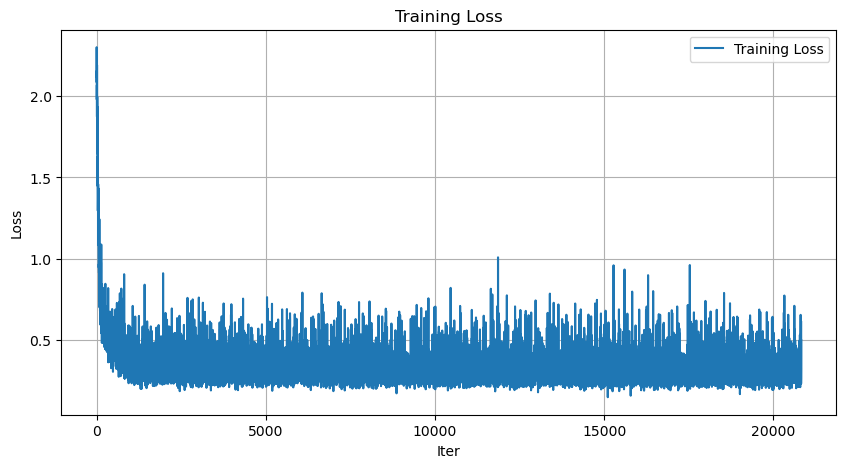

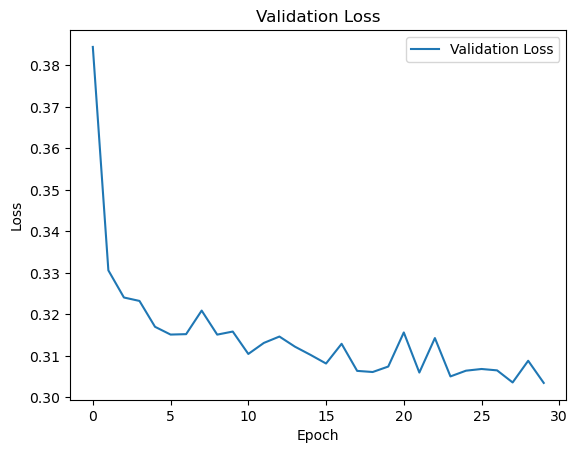

In [21]:
plot_loss(train_losses, val_losses)

In [22]:
#predict based on tabular test data
mlp_model.eval()
test_tabular_data = test_tabular_data.to(device)
with torch.no_grad():
    mlp_predictions = mlp_model(test_tabular_data)
    
#inverse output of column 2-6 since these were scaled using log10 scale.
mlp_predictions[:, 1:] = 10 ** mlp_predictions[:, 1:]
print(f"prediction size: {mlp_predictions.shape}, \nprediction result : {mlp_predictions}")

#Move predictions tensor to CPU
predictions_np = mlp_predictions.cpu().numpy()

#generate df for predictions and load to .csv
predictions_df = pd.DataFrame({'id': test['id']})

for i, col_name in enumerate(config.PREDICTOR_NAMES):
    predictions_df[col_name] = predictions_np[:, i]
    
print(f'predicton sample: {predictions_df.head(2)}')
predictions_df.to_csv('prediction_tabular.csv', index=False)

prediction size: torch.Size([6545, 6]), 
prediction result : tensor([[5.4193e-01, 1.0187e+01, 8.7414e-01, 9.7532e-01, 1.4347e+00, 2.2881e+02],
        [4.5686e-01, 1.4717e+01, 3.9316e-01, 1.4694e+00, 1.5027e+00, 3.0663e+02],
        [4.7485e-01, 1.4296e+01, 4.3505e-01, 1.4880e+00, 1.5549e+00, 3.3893e+02],
        ...,
        [4.4375e-01, 1.8990e+01, 6.3816e-01, 1.6649e+00, 1.1931e+00, 7.3840e+02],
        [4.4996e-01, 1.6351e+01, 4.1830e-01, 1.3613e+00, 1.3997e+00, 4.0588e+02],
        [5.5418e-01, 1.3175e+01, 3.7052e+00, 1.5184e+01, 1.4597e+00, 1.5655e+03]],
       device='cuda:0')
predicton sample:           id        X4        X11       X18       X50       X26       X3112
0  201238668  0.541931  10.186809  0.874138  0.975319  1.434691  228.806549
1  202310319  0.456857  14.717176  0.393156  1.469358  1.502667  306.629883


In [39]:
#Ensemble image-based and tabular-based prediction result using various weighing scale
cnn_pred_df = pd.read_csv('prediction_images.csv')
mlp_pred_df = pd.read_csv('prediction_tabular.csv')

weight_scales = [0.25, 0.5, 0.75]

#assert correct prediction column headers
assert(cnn_pred_df.columns.tolist() == mlp_pred_df.columns.tolist())
assert(cnn_pred_df.columns.tolist() == ['id'] + config.PREDICTOR_NAMES)
#assert same ids in first column
assert (cnn_pred_df['id'] == mlp_pred_df['id']).all()



#setup new weighted_df to store weighted predictions
weighted_df = pd.DataFrame(index=cnn_pred_df.index, columns=cnn_pred_df.columns)
weighted_df.iloc[:, 0] = cnn_pred_df.iloc[:, 0]


for w in weight_scales:
    for col in cnn_pred_df.columns[1:]:
        # Calculate the weighted average for each column
        weighted_df[col] = cnn_pred_df[col] * w + mlp_pred_df[col] * (1.0-w)
    weighted_df.to_csv('weighted_prediction_'+str(w)+'.csv', index=False)
    print(f"sucessfully saved weighted_prediction into a csv file of size: {weighted_df.shape}")


sucessfully saved weighted_prediction into a csv file of size: (6545, 7)
sucessfully saved weighted_prediction into a csv file of size: (6545, 7)
sucessfully saved weighted_prediction into a csv file of size: (6545, 7)


C:\Users\ekabu\AppData\Local\Temp\ipykernel_30396\1885216061.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weighted_df.iloc[:, 0] = cnn_pred_df.iloc[:, 0]
